In [ ]:
import os
import json
import time
import requests
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from functools import partial
import tiktoken

# ==========================================
# [중요] 외부 모듈 의존성 처리
# 이 코드는 책이나 튜토리얼의 일부로, 이전 챕터에서 정의된 모델(GPTModel)이 필요합니다.
# ==========================================
try:
    from previous_chapters import GPTModel, generate_and_print_sample, download_model
except ImportError:
    print("경고: 'previous_chapters' 모듈을 찾을 수 없습니다. GPTModel 등의 정의가 필요합니다.")

# ==========================================
# 1. 설정 및 데이터 로드 유틸리티
# 데이터를 인터넷에서 다운로드하거나 로컬에서 불러오는 기능을 담당합니다.
# ==========================================
def download_and_load_file(file_path, url):
    """
    지정된 경로에 파일이 없으면 URL에서 다운로드하고,
    파일을 읽어 JSON 데이터를 반환합니다.
    """
    if not os.path.exists(file_path):
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(response.text)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
    return json.loads(text_data)


def format_input(entry):
    """
    JSON 데이터의 항목을 모델이 이해할 수 있는 프롬프트 형식으로 변환합니다.
    (알파카(Alpaca) 데이터셋 스타일 포맷팅)
    """
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    # 추가 입력(Input)이 있는 경우에만 붙임
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    return instruction_text + input_text

# ==========================================
# 2. 데이터셋 및 Collate 함수 (DPO용)
# DPO는 (프롬프트, 선택된 답변, 거부된 답변)의 쌍이 필요합니다.
# ==========================================
class PreferenceDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        
        # 데이터를 미리 토큰화(Tokenization)하여 저장합니다.
        for entry in data:
            prompt = format_input(entry)
            rejected_response = entry["rejected"] # 👎 덜 선호되는 답변
            chosen_response = entry["chosen"]     # 👍 더 선호되는 답변

            # 프롬프트 부분만 따로 인코딩 (나중에 마스킹하기 위해 필요)
            prompt_tokens = tokenizer.encode(prompt)
            
            # 프롬프트 + 답변 형태로 전체 문장을 인코딩
            chosen_full_tokens = tokenizer.encode(f"{prompt}\n\n### Response:\n{chosen_response}")
            rejected_full_tokens = tokenizer.encode(f"{prompt}\n\n### Response:\n{rejected_response}")

            self.encoded_texts.append({
                "prompt": prompt_tokens,
                "chosen": chosen_full_tokens,
                "rejected": rejected_full_tokens,
            })

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

def custom_collate_fn(batch, pad_token_id=50256, allowed_max_length=None, mask_prompt_tokens=True, device="cpu"):
    """
    배치(Batch) 내의 데이터 길이를 맞추고(Padding), 마스크(Mask)를 생성하는 함수입니다.
    """
    batch_data = {
        "prompt": [],
        "chosen": [],
        "rejected": [],
        "rejected_mask": [], # Loss 계산 시 무시할 부분 (패딩 등)
        "chosen_mask": []
    }

    # 1. 배치 내에서 가장 긴 시퀀스 길이 찾기 (패딩을 위해)
    max_length_common = 0
    if batch:
        for key in ["chosen", "rejected"]:
            current_max = max(len(item[key]) + 1 for item in batch)
            max_length_common = max(max_length_common, current_max)

    # 2. 패딩 추가 및 마스크 생성
    for item in batch:
        prompt = torch.tensor(item["prompt"])
        batch_data["prompt"].append(prompt)

        for key in ["chosen", "rejected"]:
            sequence = item[key]
            # 최대 길이에 맞춰 패딩 토큰 추가
            padded = sequence + [pad_token_id] * (max_length_common - len(sequence))
            
            # 기본 마스크: 데이터가 있는 곳은 1(True), 패딩은 0(False)
            mask = torch.ones(len(padded)).bool()
            mask[len(sequence):] = False  # 패딩 부분 마스킹

            # [중요] 프롬프트 부분 마스킹 (선택적)
            # DPO는 '답변'의 확률 차이를 학습하므로, 질문(Prompt) 부분은 Loss 계산에서 제외합니다.
            if mask_prompt_tokens:
                mask[:prompt.shape[0] + 2] = False 

            batch_data[key].append(torch.tensor(padded))
            batch_data[f"{key}_mask"].append(mask)

    # 3. 텐서 변환 및 디바이스(GPU/CPU) 이동
    for key in ["chosen", "rejected", "chosen_mask", "rejected_mask"]:
        tensor_stack = torch.stack(batch_data[key])
        # 길이 제한이 있다면 자르기
        if allowed_max_length is not None:
            tensor_stack = tensor_stack[:, :allowed_max_length]
        batch_data[key] = tensor_stack.to(device)

    return batch_data

# ==========================================
# 3. DPO Loss 및 Log Probability 계산 함수
# DPO의 핵심 수학적 로직이 들어있는 부분입니다.
# ==========================================
def compute_logprobs(logits, labels, selection_mask=None):
    """
    모델의 출력(logits)과 정답(labels)을 받아 해당 정답 토큰의 로그 확률을 계산합니다.
    """
    # Auto-regressive 모델 특성상, 입력 [A, B, C]에 대해 예측은 [B, C, D]가 되므로 시프트(Shift)합니다.
    labels = labels[:, 1:].clone()
    logits = logits[:, :-1, :]
    
    log_probs = F.log_softmax(logits, dim=-1)
    
    # 실제 정답 레이블에 해당하는 확률값만 추출 (gather 사용)
    selected_log_probs = torch.gather(
        input=log_probs,
        dim=-1,
        index=labels.unsqueeze(-1)
    ).squeeze(-1)

    if selection_mask is not None:
        # 마스크도 시프트하여 적용 (패딩이나 프롬프트 영역 무시)
        mask = selection_mask[:, 1:].clone()
        selected_log_probs = selected_log_probs * mask
        
        # 유효한 토큰들의 로그 확률 평균 계산
        avg_log_prob = selected_log_probs.sum(-1) / mask.sum(-1)
        return avg_log_prob
    else:
        return selected_log_probs.mean(-1)

def compute_dpo_loss(model_chosen_logprobs, model_rejected_logprobs, 
                     reference_chosen_logprobs, reference_rejected_logprobs, beta=0.1):
    """
    DPO 손실 함수 계산:
    Policy 모델이 Reference 모델보다 'chosen' 답변을 더 선호하고, 'rejected' 답변을 덜 선호하도록 유도합니다.
    
    beta: Reference 모델에서 얼마나 벗어날지 제어하는 하이퍼파라미터 (보통 0.1~0.5)
    """
    # 모델의 (Chosen - Rejected) 로그 확률 차이
    model_logratios = model_chosen_logprobs - model_rejected_logprobs
    # 기준 모델의 (Chosen - Rejected) 로그 확률 차이
    reference_logratios = reference_chosen_logprobs - reference_rejected_logprobs
    
    # 두 비율의 차이 (Policy가 Reference보다 얼마나 더 잘 구분했는가)
    logits = model_logratios - reference_logratios
    
    # Sigmoid 후 음수 로그 (Cross Entropy와 유사) -> 이 값을 최소화하면 선호도 차이가 극대화됨
    losses = -F.logsigmoid(beta * logits)
    
    # 학습 추적용 보상(Reward) 계산 (실제 학습엔 안 쓰이고 로깅용)
    chosen_rewards = (model_chosen_logprobs - reference_chosen_logprobs).detach()
    rejected_rewards = (model_rejected_logprobs - reference_rejected_logprobs).detach()
    
    return losses.mean(), chosen_rewards.mean(), rejected_rewards.mean()

def compute_dpo_loss_batch(batch, policy_model, reference_model, beta):
    """
    하나의 배치에 대해 전체 DPO 과정을 수행하는 헬퍼 함수
    """
    # 1. 학습 중인 모델(Policy Model)의 로그 확률 계산 (기울기 계산 O)
    policy_chosen_log_probas = compute_logprobs(
        logits=policy_model(batch["chosen"]),
        labels=batch["chosen"],
        selection_mask=batch["chosen_mask"]
    )
    policy_rejected_log_probas = compute_logprobs(
        logits=policy_model(batch["rejected"]),
        labels=batch["rejected"],
        selection_mask=batch["rejected_mask"]
    )
    
    # 2. 기준 모델(Reference Model)의 로그 확률 계산 (기울기 계산 X -> 메모리 절약)
    with torch.no_grad():
        ref_chosen_log_probas = compute_logprobs(
            logits=reference_model(batch["chosen"]),
            labels=batch["chosen"],
            selection_mask=batch["chosen_mask"]
        )
        ref_rejected_log_probas = compute_logprobs(
            logits=reference_model(batch["rejected"]),
            labels=batch["rejected"],
            selection_mask=batch["rejected_mask"]
        )

    # 3. 최종 Loss 계산
    loss, chosen_rewards, rejected_rewards = compute_dpo_loss(
        model_chosen_logprobs=policy_chosen_log_probas,
        model_rejected_logprobs=policy_rejected_log_probas,
        reference_chosen_logprobs=ref_chosen_log_probas,
        reference_rejected_logprobs=ref_rejected_log_probas,
        beta=beta
    )
    return loss, chosen_rewards, rejected_rewards

# ==========================================
# 4. 평가 및 학습 루프
# 실제 모델 학습을 돌리는 메인 루프입니다.
# ==========================================
def evaluate_dpo_loss_loader(policy_model, reference_model, train_loader, val_loader, beta, eval_iter):
    """
    학습 중간에 모델 성능을 평가(Validation)하는 함수
    """
    policy_model.eval() # 평가 모드 전환 (Dropout 등 비활성화)
    with torch.no_grad():
        # 로더를 순회하며 평균 Loss 계산하는 내부 함수
        def compute_loader_metric(loader):
            total_loss, total_chosen, total_rejected = 0., 0., 0.
            num_batches = min(eval_iter, len(loader))
            if num_batches == 0: return float("nan"), float("nan"), float("nan")
            
            for i, batch in enumerate(loader):
                if i >= num_batches: break
                loss, chosen, rejected = compute_dpo_loss_batch(batch, policy_model, reference_model, beta)
                total_loss += loss.item()
                total_chosen += chosen.item()
                total_rejected += rejected.item()
            return total_loss/num_batches, total_chosen/num_batches, total_rejected/num_batches

        train_loss, train_chosen, train_rejected = compute_loader_metric(train_loader)
        val_loss, val_chosen, val_rejected = compute_loader_metric(val_loader)

    policy_model.train() # 다시 학습 모드로 전환
    return {
        "train_loss": train_loss,
        "train_chosen_reward": train_chosen,
        "train_rejected_reward": train_rejected,
        "val_loss": val_loss,
        "val_chosen_reward": val_chosen,
        "val_rejected_reward": val_rejected
    }

def train_model_dpo_simple(policy_model, reference_model, train_loader, val_loader, 
                           optimizer, num_epochs, beta, eval_freq, eval_iter, start_context, tokenizer):
    """
    전체 학습 과정을 관리하는 함수
    """
    tracking = {"train_losses": [], "val_losses": [], "tokens_seen": []}
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        policy_model.train() # 학습 모드 시작
        for batch in train_loader:
            optimizer.zero_grad() # 이전 기울기 초기화
            
            # Loss 계산
            loss, chosen_rewards, rejected_rewards = compute_dpo_loss_batch(
                batch=batch, policy_model=policy_model, reference_model=reference_model, beta=beta
            )
            
            loss.backward() # 역전파 (기울기 계산)
            optimizer.step() # 가중치 업데이트
            
            tokens_seen += batch["chosen"].numel()
            global_step += 1

            # 평가 주기마다 성능 측정 및 출력
            if global_step % eval_freq == 0:
                res = evaluate_dpo_loss_loader(
                    policy_model, reference_model, train_loader, val_loader, beta, eval_iter
                )
                tracking["train_losses"].append(res["train_loss"])
                tracking["val_losses"].append(res["val_loss"])
                tracking["tokens_seen"].append(tokens_seen)
                
                # Margin = Chosen Reward - Rejected Reward (클수록 좋음, 모델이 정답을 오답보다 더 선호한다는 뜻)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {res['train_loss']:.3f}, Val loss {res['val_loss']:.3f}, "
                      f"Train Margin {res['train_chosen_reward']-res['train_rejected_reward']:.3f}")

        # 에포크가 끝날 때마다 샘플 생성하여 육안으로 확인
        generate_and_print_sample(model=policy_model, tokenizer=tokenizer, device=loss.device, start_context=start_context)

    return tracking

### 💡 주요 핵심 포인트

1. **DPO의 원리**: 일반적인 학습과 달리 **두 개의 모델**이 필요합니다.
* `policy_model`: 학습이 되어 업데이트되는 모델 (우리가 훈련시키는 모델).
* `reference_model`: 학습되지 않고 고정된 상태로 비교 기준이 되는 모델 (보통 SFT가 완료된 모델 사용).


2. **데이터 구성**: `(Prompt, Chosen, Rejected)` 세 가지가 한 세트입니다. 모델이 `Chosen`(선호) 쪽으로 확률을 높이고 `Rejected`(비선호) 쪽으로 확률을 낮추도록 유도합니다.
3. **마스킹(Masking)**: `custom_collate_fn`에서 프롬프트 부분을 `False`로 마스킹합니다. 모델이 질문(Prompt)을 생성하는 능력은 평가하지 않고, 질문에 대한 **답변(Response)** 부분의 확률만을 가지고 Loss를 계산하기 위함입니다.


In [2]:
# ==========================================
# 5. 메인 실행 코드
# ==========================================
# 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = tiktoken.get_encoding("gpt2")

# 데이터 로드
file_path = "datas/instruction-data-with-preference.json"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/04_preference-tuning-with-dpo/instruction-data-with-preference.json"
data = download_and_load_file(file_path, url)

# 데이터 분할
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

# DataLoader 생성
customized_collate_fn = partial(
    custom_collate_fn, device=device, mask_prompt_tokens=True, allowed_max_length=1024
)

batch_size = 8
train_loader = DataLoader(PreferenceDataset(train_data, tokenizer), batch_size=batch_size, 
                            collate_fn=customized_collate_fn, shuffle=True, drop_last=True)
val_loader = DataLoader(PreferenceDataset(val_data, tokenizer), batch_size=batch_size, 
                        collate_fn=customized_collate_fn, shuffle=False)

# 모델 설정 (SFT 모델 로드)
BASE_CONFIG = {
    "vocab_size": 50257, "context_length": 1024, "drop_rate": 0.0, "qkv_bias": True,
    "emb_dim": 1024, "n_layers": 24, "n_heads": 16 # gpt2-medium config
}

file_name = "gpt2-medium-355M.pth"
model_path = f"./models/gpt2/{file_name}"
download_model(file_name, model_path)

# Policy Model (학습 대상)
policy_model = GPTModel(BASE_CONFIG)
policy_model.load_state_dict(torch.load(model_path, map_location="cpu", weights_only=True))
policy_model.to(device)

# Reference Model (고정 기준점)
reference_model = GPTModel(BASE_CONFIG)
reference_model.load_state_dict(torch.load(model_path, map_location="cpu", weights_only=True))
reference_model.to(device)
reference_model.eval()

# 학습 시작
optimizer = torch.optim.AdamW(policy_model.parameters(), lr=5e-6, weight_decay=0.01)

start_time = time.time()
num_epochs = 1
tracking = train_model_dpo_simple(
    policy_model=policy_model,
    reference_model=reference_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    num_epochs=num_epochs,
    beta=0.1,
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[2]),
    tokenizer=tokenizer
)
print(f"Training completed in {(time.time() - start_time) / 60:.2f} minutes.")

Using device: cuda
Ep 1 (Step 000000): Train loss 0.694, Val loss 0.691, Train Margin -0.018
Ep 1 (Step 000005): Train loss 0.691, Val loss 0.689, Train Margin 0.044
Ep 1 (Step 000010): Train loss 0.693, Val loss 0.687, Train Margin 0.000
Ep 1 (Step 000015): Train loss 0.692, Val loss 0.686, Train Margin 0.031
Ep 1 (Step 000020): Train loss 0.691, Val loss 0.685, Train Margin 0.049
Ep 1 (Step 000025): Train loss 0.686, Val loss 0.684, Train Margin 0.137
Ep 1 (Step 000030): Train loss 0.679, Val loss 0.683, Train Margin 0.288
Ep 1 (Step 000035): Train loss 0.687, Val loss 0.681, Train Margin 0.128
Ep 1 (Step 000040): Train loss 0.669, Val loss 0.679, Train Margin 0.486
Ep 1 (Step 000045): Train loss 0.678, Val loss 0.677, Train Margin 0.312
Ep 1 (Step 000050): Train loss 0.676, Val loss 0.675, Train Margin 0.343
Ep 1 (Step 000055): Train loss 0.675, Val loss 0.674, Train Margin 0.368
Ep 1 (Step 000060): Train loss 0.670, Val loss 0.673, Train Margin 0.472
Ep 1 (Step 000065): Train loss 

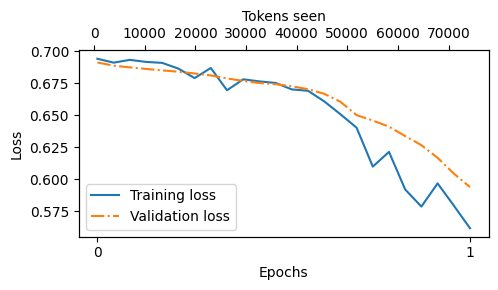

In [3]:
from previous_chapters import plot_losses
# 대안:
# from llms_from_scratch.ch05 import plot_losses
num_epochs=1

epochs_tensor = torch.linspace(0, num_epochs, len(tracking["train_losses"]))
plot_losses(
    epochs_seen=epochs_tensor,
    tokens_seen=tracking["tokens_seen"],
    train_losses=tracking["train_losses"],
    val_losses=tracking["val_losses"],
    label="loss"
)

In [4]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=reference_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    reference_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    token_ids = generate(
        model=policy_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    policy_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nReference model response:\n>> {reference_response_text.strip()}")
    print(f"\nPolicy model response:\n>> {policy_response_text.strip()}")
    print("\n-------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Reference model response:
>> ### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input: